# Classification test

In [37]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [38]:
df = pd.read_csv("data/BTCUSDT-hour-target-features.csv")
# df = pd.read_csv("data/modelv1_training_data.csv")

# dfd = pd.read_csv("data/classification_test.csv")

In [39]:
df1 = pd.concat([df, dfd[list(dfd.columns)[9:-2]]], axis=1)
df1.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore', 'target',
       'volume_cmf_50', 'volume_cmf_50_rate_200', 'volume_eom_amplified',
       'volume_fi_amplified', 'volume_mfi_50', 'volume_nvi_o_close_rate_50',
       'volatility_atr_14', 'volatility_atr_o_close', 'volatility_bb_wband_10',
       'volatility_bb_pband_100', 'volatility_bb_wband_200',
       'volatility_bb_hband_o_close', 'volatility_dc_pband_50',
       'volatility_dc_wband_10', 'volatility_pband_50', 'volatility_wband_20',
       'volatility_ui_30', 'log_rate_sma_50', 'log_rate_sma_20',
       'log_rate_sma_200', 'sma_close_50', 'log_sma_close_50', 'sma_close_20',
       'log_sma_close_20', 'sma_close_200', 'log_sma_close_200',
       'sma_diff_d_close_50', 'sma_diff_d_close_20', 'sma_diff_d_close_200',
       'log_sma_diff_d_close_50', 'log_sma_diff_d_close_20',
       'log_sma_diff_d_close_200', 'abs_sma_diff_d_close_50'],
 

In [40]:
indicators = list(df.columns)[13:]
indicators.append("target")

d = df.copy()
d.dropna(inplace=True)
close = d["close"][29000:]

d = d[list(indicators)].copy()

X = d.drop(["target", "close"], axis=1, errors="ignore")[:29000]
y = d["target"][:29000]

X_ft = d.drop(["target", "close"], axis=1, errors="ignore")[29000:]
y_ft = d["target"][29000:]

In [41]:
X_ft.columns

Index(['volume_cmf_50', 'volume_cmf_50_rate_200', 'volume_eom_amplified',
       'volume_fi_amplified', 'volume_mfi_50', 'volume_nvi_o_close_rate_50',
       'volatility_atr_14', 'volatility_atr_o_close', 'volatility_bb_wband_10',
       'volatility_bb_pband_100', 'volatility_bb_wband_200',
       'volatility_bb_hband_o_close', 'volatility_dc_pband_50',
       'volatility_dc_wband_10', 'volatility_pband_50', 'volatility_wband_20',
       'volatility_ui_30', 'log_rate_sma_50', 'log_rate_sma_20',
       'log_rate_sma_200', 'sma_close_50', 'log_sma_close_50', 'sma_close_20',
       'log_sma_close_20', 'sma_close_200', 'log_sma_close_200',
       'sma_diff_d_close_50', 'sma_diff_d_close_20', 'sma_diff_d_close_200',
       'log_sma_diff_d_close_50', 'log_sma_diff_d_close_20',
       'log_sma_diff_d_close_200', 'abs_sma_diff_d_close_50'],
      dtype='object')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

Text(-1.5, 0.5, 'Predicted label')

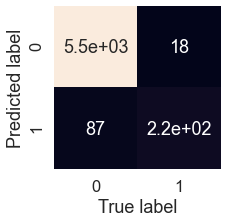

In [44]:
y_preds = model.predict(X_test)	

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                 annot=True,
                 cbar=False)
plt.xlabel("True label")
plt.ylabel("Predicted label")

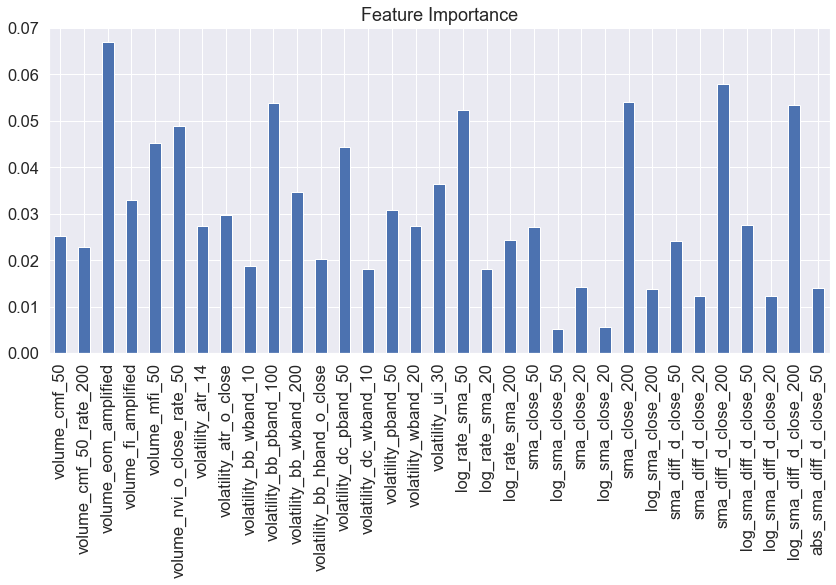

In [45]:
feature_dict = dict(zip(X_train.columns, list(model.feature_importances_)))
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False, figsize=(14, 6));

In [46]:
d = {}
d["precision"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='precision'))
d["recall"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='recall'))
d["f1"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='f1'))
d

{'precision': 0.5620774334361217,
 'recall': 0.3764016381866968,
 'f1': 0.3798498229996063}

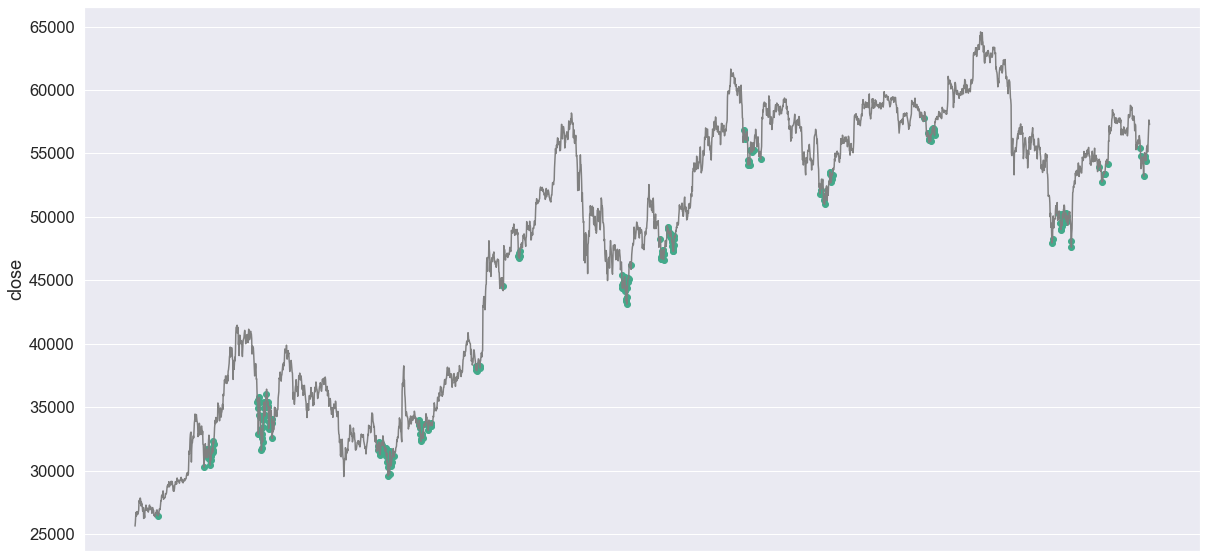

In [47]:
results = model.predict(X_ft)
scatter_results = list(map(lambda x, c: c if x == 1 else None, results, close))

s_correct = list(map(lambda x, t, c: c if x == 1 and t == 1 else None, results, y_ft, close))
s_wrong = list(map(lambda x, t, c: c if x == 1 and t == 0 else None, results, y_ft, close))
s_missed = list(map(lambda x, t, c: c if x == 0 and t == 1 else None, results, y_ft, close))

fig,ax = plt.subplots(figsize=(20, 10))

rows = len(close)
ax.scatter(range(rows), 
            scatter_results,
            color="#43aa8b")


# ax.scatter(range(rows), 
#             s_missed,
#         color="#f9c74f")

# ax.scatter(range(rows), 
#             s_correct,
#         color="#43aa8b")

# ax.scatter(range(rows), 
#             s_wrong,
#         color="#f94144")

ax.set_xlabel("time")
ax.set_ylabel("close")
ax.plot(range(rows),
        close,
        color="gray")

ax.tick_params(labelbottom=False)
ax.axes.xaxis.set_visible(False)

In [102]:
from joblib import dump, load

In [105]:
dump(model, 'models/printer_v1.joblib') 

['models/printer_v1.joblib']